In [1]:
import psycopg2 as db
import pandas as pd
import geopandas as gpd
from dotenv import dotenv_values
from senti_preprocess.senti_preprocess.twitter import remove_urls, remove_mentions, segment_hashtags

In [2]:
conn_twitter = db.connect(**dotenv_values())

In [390]:
# globals
platforms = ["Twitter", "TripAdvisor"]
user_groups = ["local", "tourist"]
group_names = ["Local users", "Tourist users"]
columns = ["pos", "neg", "neu", "compound"]
colors = ["green", "red", "blue", "olive"]
labels = ["Positive", "Negative", "Neutral", "Compound"]
legend_dict = dict(zip(columns, colors))
tw_classification = "location_within_london"
tw_geom = "place_geom"
ta_classification = "case"
ta_geom = "geom"

# Sentiment analysis on Twitter and TripAdvisor

In this notebook, a sentiment analysis on a one month sample of POI tweets and TripAdvisor reviews located in London is performed. The [Valence Aware Dictionary and sEntiment Reasoner](https://github.com/cjhutto/vaderSentiment) will be used, which is a lexicon and rule based sentiment analyzer and was sepcifically developed for analyzing social media text data. First up: Twitter. 

## Twitter

### 1. Load data

In [3]:
tweet_sample_query = """
SELECT
    sq.id, sq.text, sq.place_full_name, sq.place_geom, sq.location_within_london
FROM
    (
        SELECT
            *
        FROM
            tweets_sample
        JOIN
            user_classification as uc
        ON
            tweets_sample.user_id = uc.user_id
    ) as sq, greater_london
WHERE
    sq.place_type = 'poi'
AND
    sq.lang = 'en'
AND ST_WITHIN(sq.place_geom, greater_london.geometry)
"""

In [4]:
df = pd.read_sql(tweet_sample_query, conn_twitter)

### 2. Preprocess tweets

Three preprocessing steps are performed on each tweet:
   1. ```
   remove_urls()
   ``` removes any urls from the tweet by matching ```r"http\S+"``` and replacing any matches with a space.
   2. ```
   remove_mentions()
   ```removes any mentions from the tweet by matching ```r"@[A-Za-z0-9]+"``` and replacing any matches with a space.
   3. ```
   segment_hashtags()
   ``` finds all the hashtags in a tweet, and looks for those that contain medial capitals (also informally known as camel casing or camelCasing). These are separated into the single words, and the tweet with now segmented hashtags is returned.

In [5]:
def clean_tweet(tweet_string):
    tweet_string = remove_urls(tweet_string)
    tweet_string = remove_mentions(tweet_string)
    tweet_string = segment_hashtags(tweet_string)
    return tweet_string

In [6]:
df["cleaned_tweet"] = df["text"].apply(clean_tweet)

In [7]:
# Sample exploration
for i in range(20):
    print("{:-^50}".format(i))
    for column, descr in zip(["text", "cleaned_tweet"], ["UNCLEANED", "CLEANED"]):
        print(f'{descr}:\n {df.iloc[i][column]}')
    

------------------------0-------------------------
UNCLEANED:
 Merry Christmas from me and my lychee martini 🎄❤️ https://t.co/HbdX8SnBZc
CLEANED:
 Merry Christmas from me and my lychee martini 🎄❤️  
------------------------1-------------------------
UNCLEANED:
 @missionswl #Emmanuel #God in #Christ #Jesus
is with us #ChristmasDay #yesterday #TOMORROWFOREVER #CMCWorship #AllareWelcome
Chelsea Fulham Methodist Church
Revd Mark Davenport minister https://t.co/RONFPHmgM7
CLEANED:
    Emmanuel  God in  Christ  Jesus
is with us   Christmas Day yesterday TOMORROWFOREVER CMC Worship  Allare Welcome
Chelsea Fulham Methodist Church
Revd Mark Davenport minister  
------------------------2-------------------------
UNCLEANED:
 Ever wondered what Jeremy @theJeremyVine does on Christmas Day? Well, now you know...
#ChristmasDay #cycling #Battersea https://t.co/wtqZkybOAF
CLEANED:
 Ever wondered what Jeremy   does on Christmas Day? Well, now you know...
 Christmas Day cycling  Battersea  
-------------

The cleaned tweets look good, and the hashtag segmentation seems to work as expected. So let's feed the data into the analyzer

### 3. Sentiment analysis

In [8]:
import vaderSentiment.vaderSentiment as vader

In [9]:
senti_analyzer = vader.SentimentIntensityAnalyzer()

In [10]:
def calculate_sentiment(series):
    tweet = series["cleaned_tweet"]
    sentiment = senti_analyzer.polarity_scores(tweet)
    for key in sentiment.keys():
        series[key] = sentiment[key]
    return series

In [11]:
df = df.apply(calculate_sentiment, axis=1)

The sentiment analysis worked, so a deeper look at the results would be appropriate.

In [13]:
from matplotlib import pyplot as plt
import numpy as np
plt.rc('font', family='Helvetica')

In [255]:
def polarity_plot(df, user_classification_column, alpha, plot_args={}, subplot_args={}, grid_args={}):
    global user_groups, group_names, columns, colors, legend_dict
    bins = ([np.arange(0, 1.1, 0.1)] * 3) + [np.arange(-1, 1.1, 0.2)]
    
    fig, axs = plt.subplots(len(user_groups), len(columns), sharex="col", **plot_args)
    for g_ix, (group, group_name) in enumerate(zip(user_groups, group_names)):
        dframe = df.loc[df[user_classification_column] == group]
        for c_ix, (column, color) in enumerate(zip(columns, colors)):
            axs[g_ix][c_ix].hist(dframe[column], bins=bins[c_ix], facecolor=color, alpha=alpha, **subplot_args)
            axs[g_ix][c_ix].set_title(f"Distribution of {labels[c_ix].lower()} polarity among {group_name.lower()}")
            axs[g_ix][c_ix].grid(True, which="both", **grid_args)
            
    plt.tight_layout()

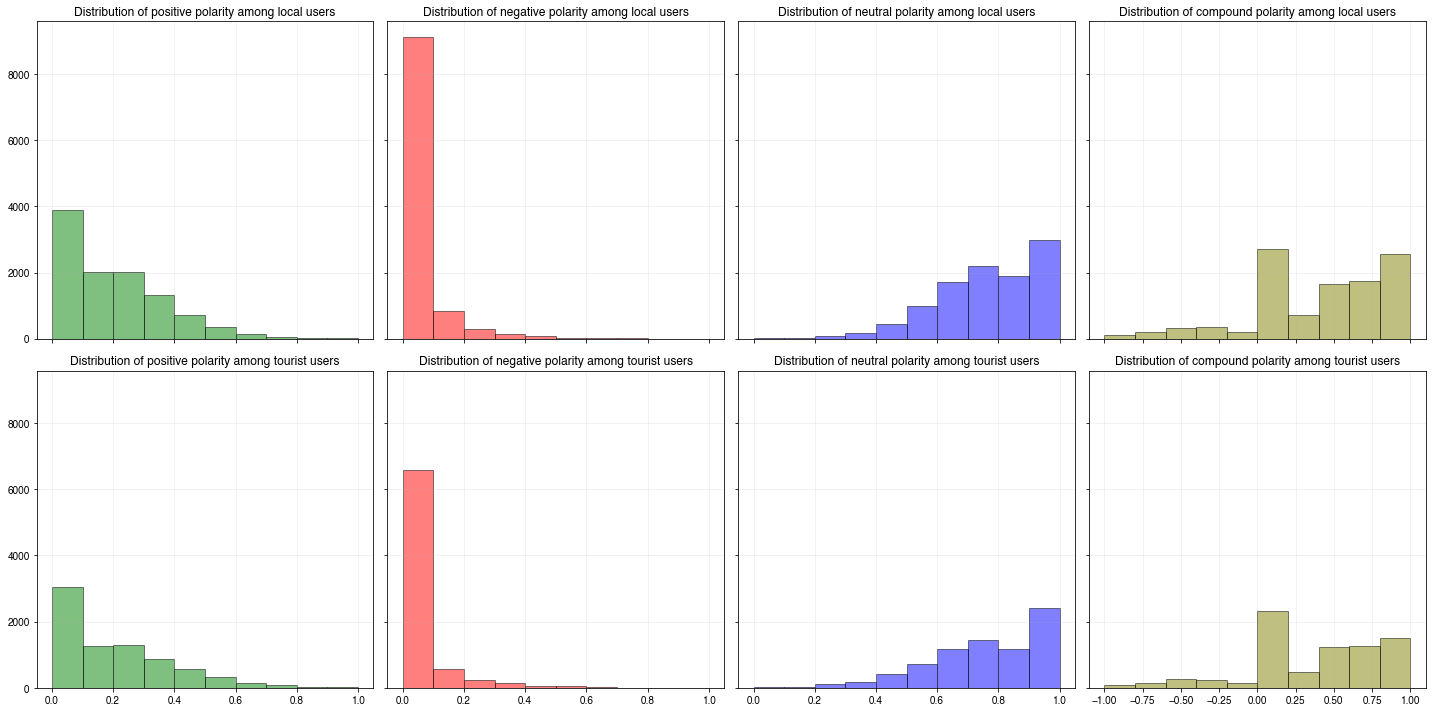

In [330]:
polarity_plot(df, 
            tw_classification,
            alpha=0.5,
            plot_args={"figsize": (20,10), "sharey": True},
            subplot_args={"edgecolor": "black"},
            grid_args={"alpha": 0.3, "linewidth": 0.5},
             )

In [16]:
from IPython.display import Markdown

In [17]:
def pretty_print_row(df, row_indices, color_dict, text_col):
    markdown = ""
    for i in row_indices:
        markdown = add_to_markdown(markdown, "{:-^75}".format(i))
        markdown = add_to_markdown(markdown, df.iloc[i][text_col])
        
        for key in color_dict.keys():
            markdown = add_to_markdown(markdown, df.iloc[i][key], color=color_dict[key])
    return markdown

def add_to_markdown(str_1, str_2, color="black"):
    str_1 = str(str_1)
    str_2 = str(str_2)
    
    if color=="black":
        return str_1 + str_2 + "<br>"
    else:
        return str_1 + "<p style=color:{}>".format(color) + str_2 + "</p>"

In [18]:
def get_high_polarity_tweets(df, quantile=0.9, max_tweets=50):
    polarity_dict = {}
    for polarity in ["pos", "neg"]:
        quantile = df[polarity].quantile(quantile)
        polarity_dict[polarity] = df[polarity].sort_values(ascending=False).loc[df[polarity] > quantile].index[:max_tweets]
    return polarity_dict

In [22]:
high_polarity_tweets = get_high_polarity_tweets(df=df, max_tweets=50)
markdown = pretty_print_row(df=df, row_indices=high_polarity_tweets["pos"], color_dict=legend_dict, text_col="text")
Markdown(markdown)

-----------------------------------5453------------------------------------<br>Classy https://t.co/8AnPU2MifH<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------14843-----------------------------------<br>@Lloydstevens29 Beautiful<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------7476------------------------------------<br>@10DowningStreet @BorisJohnson @realDonaldTrump 
@BorisJohnson Congratulations https://t.co/DX3cSdNTcF<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------16574-----------------------------------<br>Heaven https://t.co/5bOFimGKs9<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------9152------------------------------------<br>pretty https://t.co/ydRuSH3Zye<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------11000-----------------------------------<br>Lovely<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------5089------------------------------------<br>breathtaking. @WinterWonderLDN https://t.co/xDhf1bjsbA<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------7753------------------------------------<br>Pretty https://t.co/wA6rXJFl7F<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------11044-----------------------------------<br>love @clairo 💖💖 https://t.co/e97ouT4qJF<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------9247------------------------------------<br>Focused https://t.co/zzYtdtkyuA<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------1537------------------------------------<br>Nice @DegenerateFoxUK https://t.co/3QJrf74mWX<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------23231-----------------------------------<br>@mseriesMMXIV Thanks<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------6331------------------------------------<br>Hope ✨ https://t.co/Ex1oRZUtSn<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------3805------------------------------------<br>@DJNoreenKhan Lovely @DJNoreenKhan 
@realDonaldTrump https://t.co/NKVma9rlm2<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------9549------------------------------------<br>beauty https://t.co/EVRDBDNYQM<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------12045-----------------------------------<br>@FatWhiteFamily  Cheers https://t.co/MIN39WJ359<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------12047-----------------------------------<br>@work1ngmensclub  cheered https://t.co/ou9i42k5cb<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------7754------------------------------------<br>Pretty https://t.co/wA6rXJFl7F<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------6588------------------------------------<br>Hope. https://t.co/DFRlK8mdAD<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------22382-----------------------------------<br>Excited!! https://t.co/UZJrqCwFfz<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------17739-----------------------------------<br>Gratitude. https://t.co/sv8AEx7GL5<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------14400-----------------------------------<br>Cool https://t.co/FnmKa8CWKD<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------5031------------------------------------<br>Help<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------22648-----------------------------------<br>@julietmusical Amazing!! https://t.co/eQyKRkYu56<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------1775------------------------------------<br>fun fun fun https://t.co/10LU6KDApY<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------14033-----------------------------------<br>@TheSun Classy<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------16436-----------------------------------<br>thanks @LewisCapaldi https://t.co/21eghK5VFx<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------10709-----------------------------------<br>@KieranNdl Nice<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------3061------------------------------------<br>Thriller! https://t.co/kJH6pylVNY<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------4867------------------------------------<br>@realpreityzinta @realDonaldTrump 
cool! https://t.co/lKoXW2WNbv<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------2124------------------------------------<br>@salmahayek @realDonaldTrump 
Cool! https://t.co/HJyfBzoNfI<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------2129------------------------------------<br>@mouthwaite @BlenheimPalace @cescloveslife @realDonaldTrump 
Cool! https://t.co/11fkj7sWhG<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------20505-----------------------------------<br>@drjanaway Yes! Yes! YES!<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------1613------------------------------------<br>@Gelderdgary1979 @LUFC @FulhamFC Definitely<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------3017------------------------------------<br>@thomasgfarrellj @babyleggs727 beautiful thankyou 👌<br><p style=color:green>0.909</p><p style=color:red>0.0</p><p style=color:blue>0.091</p>-----------------------------------10508-----------------------------------<br>Lovely Jubbly 👌 @dancafc80 https://t.co/iFFiKyHP01<br><p style=color:green>0.909</p><p style=color:red>0.0</p><p style=color:blue>0.091</p>-----------------------------------21182-----------------------------------<br>Lovely Day 💗 https://t.co/h0LlXsE3xW<br><p style=color:green>0.907</p><p style=color:red>0.0</p><p style=color:blue>0.093</p>-----------------------------------13828-----------------------------------<br>Feeling loved ♥️ https://t.co/A8DSbLUKmA<br><p style=color:green>0.906</p><p style=color:red>0.0</p><p style=color:blue>0.094</p>-----------------------------------19679-----------------------------------<br>365 days 👌👌👌 https://t.co/CvbHkNv3Pp<br><p style=color:green>0.902</p><p style=color:red>0.0</p><p style=color:blue>0.098</p>-----------------------------------16341-----------------------------------<br>@226mf_ Loveyouuuu💗💗💗<br><p style=color:green>0.898</p><p style=color:red>0.0</p><p style=color:blue>0.102</p>-----------------------------------10671-----------------------------------<br>pretty pretty london ✨ https://t.co/3L1mmIogyc<br><p style=color:green>0.897</p><p style=color:red>0.0</p><p style=color:blue>0.103</p>-----------------------------------8671------------------------------------<br>Gorgeous 💛 https://t.co/tDkMwZih9a<br><p style=color:green>0.891</p><p style=color:red>0.0</p><p style=color:blue>0.109</p>-----------------------------------7101------------------------------------<br>smile baby smile :) https://t.co/aVDV52dC6s<br><p style=color:green>0.889</p><p style=color:red>0.0</p><p style=color:blue>0.111</p>-----------------------------------11045-----------------------------------<br>With @GarthTroubadour 

Great pleasure https://t.co/LPS9WL9g9n<br><p style=color:green>0.886</p><p style=color:red>0.0</p><p style=color:blue>0.114</p>-----------------------------------12586-----------------------------------<br>Happy Anniversary gorgeous. https://t.co/NuDIE3t8vV<br><p style=color:green>0.885</p><p style=color:red>0.0</p><p style=color:blue>0.115</p>-----------------------------------19765-----------------------------------<br>Yes! Great name! https://t.co/PoYcSvRl76<br><p style=color:green>0.881</p><p style=color:red>0.0</p><p style=color:blue>0.119</p>-----------------------------------6733------------------------------------<br>✨ Enchanted Eltham ✨ https://t.co/tVL1IDUQs4<br><p style=color:green>0.878</p><p style=color:red>0.0</p><p style=color:blue>0.122</p>-----------------------------------8254------------------------------------<br>Good night xoxo https://t.co/je1yHoJLwo<br><p style=color:green>0.873</p><p style=color:red>0.0</p><p style=color:blue>0.127</p>-----------------------------------18358-----------------------------------<br>happy place. 💙💗 https://t.co/ngkKXjgLP9<br><p style=color:green>0.873</p><p style=color:red>0.0</p><p style=color:blue>0.127</p>------------------------------------154------------------------------------<br>JUSTICE. LIBERTY. SCIENCE. https://t.co/p4OrrZP1Mq<br><p style=color:green>0.872</p><p style=color:red>0.0</p><p style=color:blue>0.128</p>

In [23]:
from scipy.stats import ttest_ind

In [257]:
def print_t_test(df, user_classification_column, **kwargs):
    global columns, colors, labels 
    result = ""
    for col, col_name, color in zip(columns, labels, colors):
        t_test, p = ttest_ind(df[col].loc[df[user_classification_column] == "local"], df[col].loc[df[user_classification_column] == "tourist"], **kwargs)
        result += f"t-test for <a style=color:{color}><b>{col_name}</b></a> polarity:<br>"
        result += f"t-test statistic: {round(t_test, 2)} || p-value: {round(p, 3)}"
        result += "<br><br>"
    return Markdown(result)

In [331]:
print_t_test(df, tw_classification, equal_var=False)

t-test for <a style=color:green><b>Positive</b></a> polarity:<br>t-test statistic: -1.05 || p-value: 0.293<br><br>t-test for <a style=color:red><b>Negative</b></a> polarity:<br>t-test statistic: -1.32 || p-value: 0.188<br><br>t-test for <a style=color:blue><b>Neutral</b></a> polarity:<br>t-test statistic: 1.66 || p-value: 0.097<br><br>t-test for <a style=color:olive><b>Compound</b></a> polarity:<br>t-test statistic: 6.1 || p-value: 0.0<br><br>

From this, it is evident, that the sentiments themselves do differ between tourists and locals, although the cause of this requires further investigation, for example whether a handful of very active users in the locals group leads to a contribution bias that explains the abundance of highly positive compound tweet sentiments.

## TripAdvisor

### 1. Load data

In [27]:
env = dotenv_values()
env["dbname"] = "TripAdvisor"
conn_ta = db.connect(**env)

In [28]:
tripadvisor_sample_query = """
SELECT
    *
FROM
    (
    SELECT
        reviews.id, reviews.title, reviews.rating, reviews.date::date, reviews.full, 
        reviews.user_profile, reviews.attr_id, case when ta_user_classification.class_within_gl then 'local' else 'tourist' end, attractions.geom
    FROM
        reviews
    JOIN
        users
    ON
        users.profile = reviews.user_profile
    JOIN
        attractions
    ON
        reviews.attr_id = attractions.id
    JOIN
        ta_user_classification
    ON
        reviews.user_profile = ta_user_classification.profile
         ) as s 
WHERE
    date BETWEEN SYMMETRIC '2019-11-30' AND '2020-01-01'
"""

In [29]:
df_ta = pd.read_sql(tripadvisor_sample_query, conn_ta)

### 2. Preprocessing

Unlike tweets, TripAdvisor reviews are required to have at least 200 characters, but can be significantly longer. This leads to most reviews being written in a less informal way. Furthermore, TripAdvisor forbids including any URLs, while mentions and hashtags are not supported features on the platform. This makes the preprocessing steps taken for Twitter largely unnecessary.

Furthermore, the VADER SA eliminates the need for preprocessing steps typical to NLP problems, like stemming or lemmatization. Therefore, let's have a look at a review sample and check whether any other preprocessing might be necessary.

In [31]:
np.random.seed(0)
ta_sample = np.random.randint(0, df_ta.shape[0], 10)

In [32]:
for i in ta_sample:
    print(df_ta.iloc[i]["full"])

CROWDED but very nice. super clean. there are a lot of parks around as well. the statues that are close by are gorgeous too. be careful of pick pockets. go early so you are not dealing with saying space when you want to take photos. great photo opps. 
Passed by here for a quick introductory tour and a lunchtime lecture with the Royal Astronomical Society, brilliant building the library looked really cozy as well, and its all live streamed.

check it out
Had a brilliant visit to The Old Truman Brewery today for Festive Friends.  Very easy to get to we went Waterloo, Bank, Liverpool Street and a short walk via Spitalfields Market.  The venue is brilliant for this event as there is loads of space for each of the areas for photos.  The staff are very friendly and more than happy to take pics for you.  We had so much fun from being the floating heads to meeting the holiday armadillo.  We stopped for our free mulled wine and watched festive clips of Friends on a huge screen while we waited f

### 3. Sentiment Analysis

In [33]:
def calculate_review_sentiment(series):
    tweet = series["full"]
    sentiment = senti_analyzer.polarity_scores(tweet)
    for key in sentiment.keys():
        series[key] = sentiment[key]
    return series

In [34]:
df_ta = df_ta.apply(calculate_review_sentiment, axis=1)

In [172]:
high_pol_reviews = get_high_polarity_tweets(df_ta, max_tweets=12)
markdown = pretty_print_row(df_ta, high_pol_reviews["neg"], legend_dict, text_col="full")
Markdown(markdown)

-----------------------------------2914------------------------------------<br>Very disappointing. House drinks included with no name spirits, limited food, broken charging points. This is one of the worst lounges I’ve been in and deffo wouldn’t come back.<br><p style=color:green>0.0</p><p style=color:red>0.381</p><p style=color:blue>0.619</p>-----------------------------------2831------------------------------------<br>Nothing really to say but it’s overcrowded and not sure what the way forward is. But think unfair you pay more for such a poor service.<br><p style=color:green>0.0</p><p style=color:red>0.359</p><p style=color:blue>0.641</p>-----------------------------------3631------------------------------------<br>We visited Hyde Park tk see winter wonderland. It was chaos. No organisation, massive fight broke out and it took 2 hours to get in. Shame as it is such a beautiful place. <br><p style=color:green>0.086</p><p style=color:red>0.318</p><p style=color:blue>0.596</p>-----------------------------------3715------------------------------------<br>This was a great museum. The history of the prison was artfully presented and I can’t believe how much we learned about this horrifying history of torture and mistreatment. Seeing the actual torture devices was fascinating and a bit terrifying too. <br><p style=color:green>0.125</p><p style=color:red>0.316</p><p style=color:blue>0.559</p>------------------------------------934------------------------------------<br>Really, don’t bother ...,,,,,,,,,,,,,,,,,,,,,Seats uncomfortable   Sooooooo bad.  ............ dancing out of time...... tall skinny snowman when film is cute and round......<br><p style=color:green>0.104</p><p style=color:red>0.305</p><p style=color:blue>0.591</p>-----------------------------------3269------------------------------------<br>London underground os old. Trains are old, stations are old. Very narrow, and scaring.

Not the best place to be in case of a Panic Situation.<br><p style=color:green>0.0</p><p style=color:red>0.299</p><p style=color:blue>0.701</p>-----------------------------------2647------------------------------------<br>It is an expensive place to have a nap. Food is mediocre and the choise was underwhelming. But the worst of it was that I had to witness a racist rant coming from a British traveller toward a Muslim family. The staff managed it very poorly, and had the Muslim family removed rather then the racist man who had started the argument. I had to ask the staff to have him removed before anything happened to that racist man.<br><p style=color:green>0.0</p><p style=color:red>0.281</p><p style=color:blue>0.719</p>-----------------------------------2138------------------------------------<br>The afternoon tea was so bad it's not worth description Service was diabolical The Chef should be sacked terrible food It ruined our day in London I could make a better afternoon tea! Close it down<br><p style=color:green>0.062</p><p style=color:red>0.272</p><p style=color:blue>0.666</p>-----------------------------------2963------------------------------------<br>Very disappointing where have all the market and craft stalls gone replaced with food chains lost its character <br><p style=color:green>0.0</p><p style=color:red>0.266</p><p style=color:blue>0.734</p>-----------------------------------3407------------------------------------<br>Market disappointing - too repetitive ! 
Food stalls are ok and the food we had was hot and filled us up . Poor signage around the park so you struggle to find things. toilets are so disgusting ! No toilet paper and no paper towels. Even after asking an attendant they just shrugged it off . Seems a lot smaller than last year <br><p style=color:green>0.028</p><p style=color:red>0.264</p><p style=color:blue>0.708</p>-----------------------------------3557------------------------------------<br>Had a quick look around but even just wandering through a few areas there’s an amazing amount to see. I’m still embarrassed about the stuff that the Brits gave stolen from around the world and yet still failed to return 😕<br><p style=color:green>0.091</p><p style=color:red>0.262</p><p style=color:blue>0.647</p>------------------------------------94-------------------------------------<br>Too bad too much immigrant makes strolling london feel not safe. They’re all everywhere. Pretending to be nice but actually bad people. Becareful for the immigrant pickpockets.  <br><p style=color:green>0.092</p><p style=color:red>0.257</p><p style=color:blue>0.651</p>

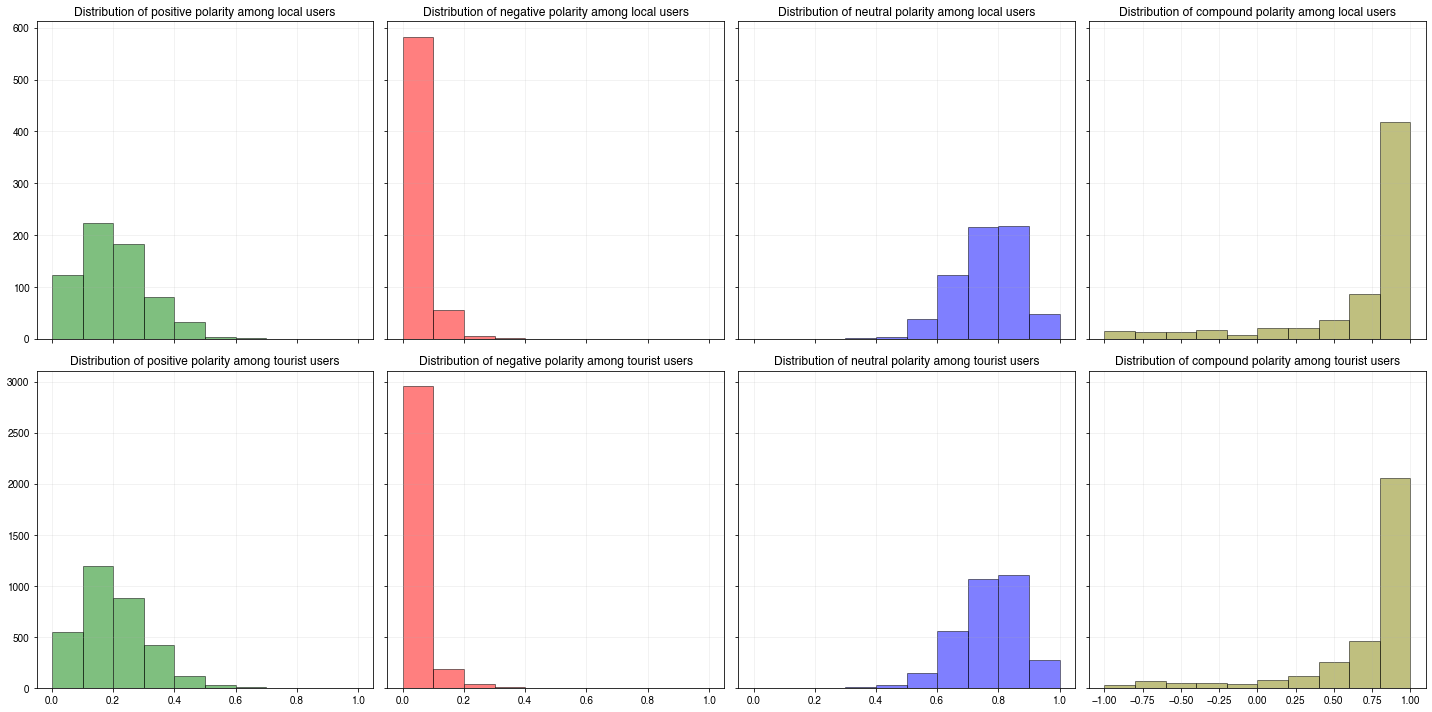

In [171]:
polarity_plot(df_ta, 
            "case",
            alpha=0.5,
            plot_args={"figsize": (20,10), "sharey": "row"},
            subplot_args={"edgecolor": "black"},
            grid_args={"alpha": 0.3, "linewidth": 0.5},
             )

In [148]:
print_t_test(df_ta, "case", equal_var=False)

t-test for <a style=color:green><b>Positive</b></a> polarity:<br>t-test statistic: 0.27<br>p-value: 0.787<br><br>t-test for <a style=color:red><b>Negative</b></a> polarity:<br>t-test statistic: 1.96<br>p-value: 0.05<br><br>t-test for <a style=color:blue><b>Neutral</b></a> polarity:<br>t-test statistic: -1.18<br>p-value: 0.237<br><br>t-test for <a style=color:Olive><b>Compound</b></a> polarity:<br>t-test statistic: -1.38<br>p-value: 0.167<br><br>

Not surprisingly, the sentiment distributions of Twitter and TripAdvisor are vastly different. Generally, TripAdvisor reviews are more sentiment-laden, which is expected, since they are longer and people use it explicitly to describe experiences.

That being said, there are differences between tourists' and locals' sentiment, but they differ across the two platforms: while on Twitter, a significant difference was found in the compound polarity, while on TripAdvisor the only significant difference was in negative polarity.

## Plot results

### 1. Plot point distribution of content

In [396]:
from geopandas import GeoDataFrame
import contextily as cx
from shapely import wkb
from collections import namedtuple
from pointpats import centrography
from matplotlib.patches import Ellipse
UserCount = namedtuple("UserCount", [*[u +"s" for u in user_groups], "local_percentage"])

In [404]:
def get_pop_size(df, user_classification, geom):
    global user_groups
    sizes = [df.loc[df[user_classification] == group][geom].unique().shape[0] for group in user_groups]
    ratio = round((sizes[1] / sum(sizes)), 2)
    sizes = UserCount(*sizes, ratio)
    return sizes

In [406]:
ll = "EPSG:4326" # 2D WGS 84
sm = "EPSG:3857" # Spherical Mercator

population_sizes = {}
for dataframe, platform, classification_column, geom in zip([df, df_ta], platforms, [tw_classification, ta_classification], [tw_geom, ta_geom]):
    population_sizes[platform] = get_pop_size(dataframe, classification_column, geom)
population_sizes
# place_counts = {}
# for dataframe, geom, platform in zip([df, df_ta], [tw_geom, ta_geom], platforms):
#     place_counts[platform] = dataframe[geom].unique().shape[0]
# place_counts

{'Twitter': UserCount(locals=4180, tourists=2710, local_percentage=0.39),
 'TripAdvisor': UserCount(locals=253, tourists=459, local_percentage=0.64)}

In [522]:
def content_count_plot(df=None, 
                       user_classification=None,
                       ctx=True,
                       same_sample_size=False,
                       platform=None,
                       geom_col=None, cx_args={}, plot_args={}, subplot_args={},legend_args={}):
    global colors, columns, legend_dict, labels, user_groups, group_names, population_sizes
    
    fig, axs = plt.subplots(1,2, **plot_args)
    for index, (group, group_label) in enumerate(zip(user_groups, group_names)):
        df_group = df.loc[df[user_classification] == group].groupby(by=geom_col).count().reset_index()[[geom_col, "id"]].rename(columns={"id": "count"})
        df_group["new_geometry"] = df_group[geom_col].apply(lambda x: wkb.loads(x, hex=True))
        gdf = GeoDataFrame(df_group, geometry="new_geometry", crs=ll)
        if same_sample_size:
            sample_size = min(population_sizes[platform].locals, population_sizes[platform].tourists)-1
            gdf = gdf.sample(sample_size)
            axs[index].set_title(f"{group_label} point pattern on {platform} (n = {sample_size})")
        else:
            axs[index].set_title(f"{group_label} point pattern on {platform}")
        gdf.plot(color="black", ax=axs[index], alpha=0.8, **subplot_args)
        cx.add_basemap(axs[index], crs=ll, **cx_args)
        
        # standard deviational ellipse
        points = [[a.xy[0][0], a.xy[1][0]] for a in gdf["new_geometry"]]
        mean_center = centrography.mean_center(points)
        major, minor, rotation = centrography.ellipse(points)
        ellipse = Ellipse(xy=mean_center, 
                  width=major*2,
                  height=minor*2, 
                  angle = np.rad2deg(rotation),
                  facecolor='none', 
                  edgecolor='#ffa822', linestyle='--', linewidth=2.5, alpha=1,
                  label='Std. Ellipse')
        axs[index].add_patch(ellipse)

        
        plt.tight_layout()

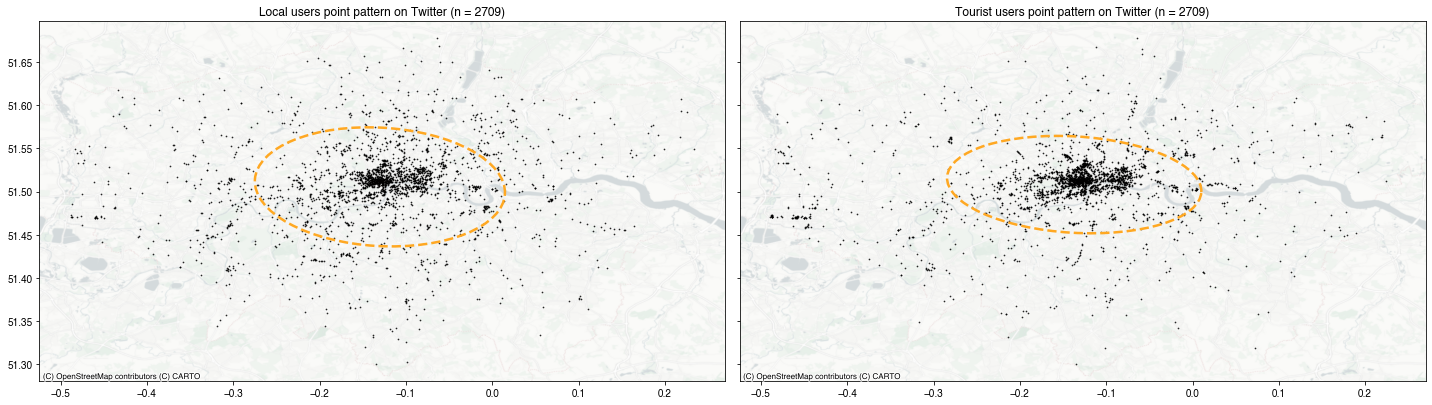

In [523]:
content_count_plot(df, 
                   user_classification=tw_classification, 
                   geom_col="place_geom", 
                   same_sample_size=True,
                   platform="Twitter",
                   plot_args={"figsize": (20,20), "sharey": True, "sharex": True},
                   subplot_args={"markersize": 0.5},
                   cx_args={"source": cx.providers.CartoDB.PositronNoLabels}
                  )

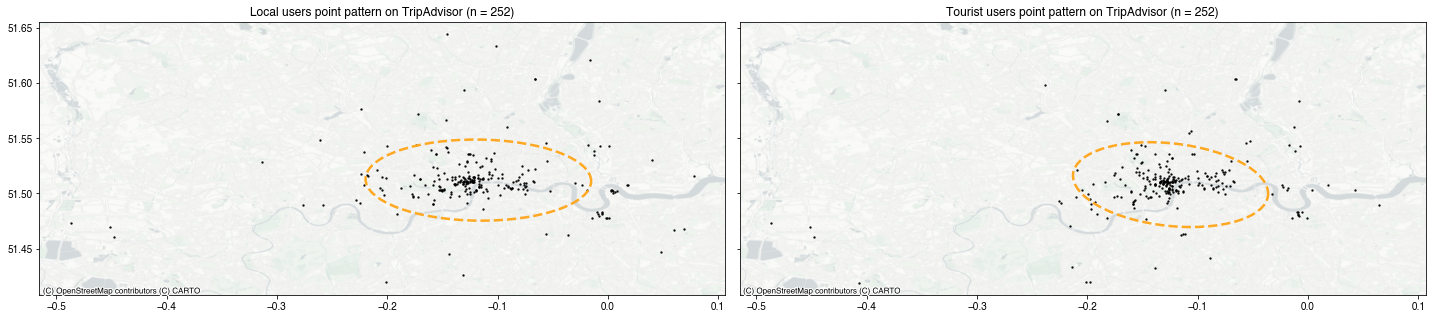

In [524]:
content_count_plot(df_ta, 
                   user_classification=ta_classification, 
                   geom_col=ta_geom, 
                   same_sample_size=True,
                   platform="TripAdvisor",
                   plot_args={"figsize": (20,20), "sharey": True, "sharex": True},
                   subplot_args={"markersize": 2},
                   cx_args={"source": cx.providers.CartoDB.PositronNoLabels}
                  )